## **Customer Segmentation - Mall Customers data set**

Data: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

___________________________________________________________________________________________________________________________

#### **1. Data Exploration**
See customer_segmentation _eda.ipynb

___________________________________________________________________________________________________________________________

#### **2. Model Development**

<span style="color:#ed8315">Based on the shape of the data in the correlation plot between <u>Annual_Income and Spending_Score</u> (See EDA file) where we see distinct relatively seperate clusters, I am moving foreword with **k-Means for clustering**</span>

In [2]:
import pandas as pd

import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics


**<u>Data Preperation</u>**

In [3]:
df = pd.read_csv('data/customers.csv')

# Drop ID Column
df = df.drop(['CustomerID'], axis = 1)

# Based on EDA - drop Gender column
df = df.drop(['Gender'], axis = 1)

In [4]:
df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


**<u>Feature Engineering</u>**
* As the range for the continuous variables differs **scaling** is requiered
* **Robust-Scaler** was chosen as the data does not seem to be distributed normaly and in one variable there are outliers

In [5]:
# Scale continuous variables
scaler = RobustScaler()

for var in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    newvar_name = 'scaled_' + var
    scaler.fit(df[[var]])
    df[[newvar_name]] = scaler.transform(df[[var]])

In [6]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),scaled_Age,scaled_Annual Income (k$),scaled_Spending Score (1-100)
0,19,15,39,-0.839506,-1.273973,-0.287582
1,21,15,81,-0.740741,-1.273973,0.810458
2,20,16,6,-0.790123,-1.246575,-1.150327
3,23,16,77,-0.641975,-1.246575,0.705882
4,31,17,40,-0.246914,-1.219178,-0.261438


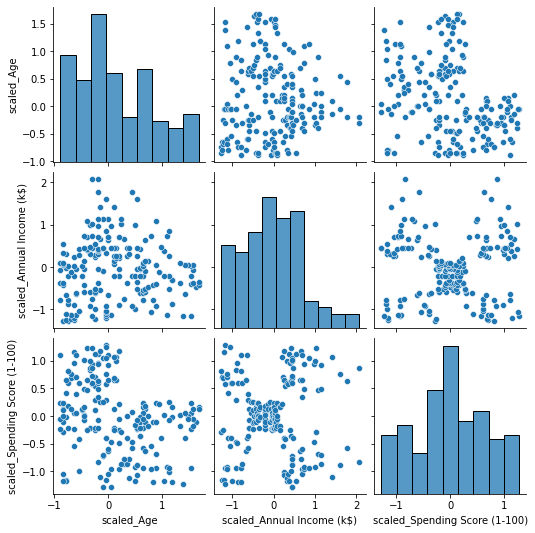

In [7]:
sns.pairplot(df.iloc[:,3:])

**<u>Clustering with K-Means</u>**

***1. Anual Income vs. Spending Score***

In [55]:
df_1 = df.iloc[:,4:]

In [57]:
def clustering_alg(data, k):
    k_list = list(range(2, k+1))
    inertia_list=[]
    silhouette_scores = []
    
    for k in k_list:
        model = KMeans(
            n_clusters = k,
            init='k-means++', 
            max_iter=500, 
            random_state=42)
        model.fit(data)
        labels = model.labels_
        inertia_list.append(model.inertia_)
        silhouette_scores.append(metrics.silhouette_score(data, labels))
    
    df_inertia = pd.DataFrame({'k_value': list(range(2, k+1)),
                               'inertia': inertia_list})
    df_silhouette = pd.DataFrame({'k_value': list(range(2, k+1)),
                                  'silhouette_score': silhouette_scores})

    return df_inertia, df_silhouette

In [58]:
df_inertia, df_silhouette = clustering_alg(df_1, 10)

In [59]:
# visualization of k-means and inertia
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_inertia['k_value'], 
                         y = df_inertia['inertia'],
                         mode='lines+markers'))

fig.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  xaxis_title = 'K values',
                  yaxis_title = 'Cluster sum of squared distances (inertia)')

fig.show()

In [60]:
# visualization of k-means and silhouette_scores 
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_silhouette['k_value'], 
                         y = df_silhouette['silhouette_score'],
                         mode='lines+markers'))

fig.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  xaxis_title = 'K values',
                  yaxis_title = 'silhouette_score')

fig.show()

<span style="color:#ed8315">>>> Here we can see that around **k=5** graph starts to platto and silouette peaks, which matches what was found in the EDA scatter plot</span>

In [67]:
# model with k = 5
model_5 = KMeans(
            n_clusters = 5,
            init='k-means++', 
            max_iter=500, 
            random_state=42)

model_5.fit(df_1)

centroids_5 = model_5.cluster_centers_
df_centroids = pd.DataFrame(centroids_5, columns=['X', 'Y'])
labels = model_5.labels_

In [68]:
df_1['label'] = labels

In [70]:
df_1

,scaled_Annual Income (k$),scaled_Spending Score (1-100),label
0,-1.273973,-0.287582,3
1,-1.273973,0.810458,4
2,-1.246575,-1.150327,3
3,-1.246575,0.705882,4
4,-1.219178,-0.261438,3
...,...,...,...
195,1.602740,0.758170,2
196,1.767123,-0.575163,0
197,1.767123,0.627451,2
198,2.068493,-0.836601,0


<AxesSubplot:xlabel='scaled_Annual Income (k$)', ylabel='scaled_Spending Score (1-100)'>

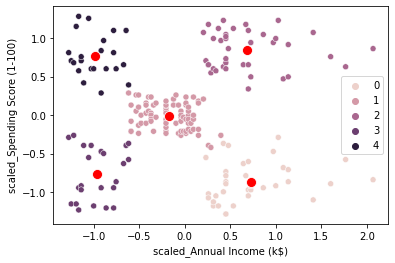

In [77]:
sns.scatterplot(data=df_1, x='scaled_Annual Income (k$)', y='scaled_Spending Score (1-100)', hue='label')
sns.scatterplot(data=df_centroids, x='X', y='Y', color='r', s=100, legend=True)